In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../data/train.csv', index_col=0)

In [3]:
print(df.columns)
print(df.shape)

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(891, 11)


In [4]:
df.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
415,1,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,STON/O 2. 3101269,7.925,NaN,S
558,0,1,"Robbins, Mr. Victor",male,NaN,0,0,PC 17757,227.525,NaN,C
72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.900,NaN,S
85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.500,NaN,S
278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.000,NaN,S


In [5]:
# The age column has nas, but they don't seem special at first sight.
# I'll fill them with the median

df[df['Age'].isnull()].sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
503,0,3,"O'Sullivan, Miss. Bridget Mary",female,NaN,0,0,330909,7.6292,NaN,Q
585,0,3,"Paulner, Mr. Uscher",male,NaN,0,0,3411,8.7125,NaN,C
640,0,3,"Thorneycroft, Mr. Percival",male,NaN,1,0,376564,16.1000,NaN,S
265,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q


In [6]:
# Substitute missing ages with the median (28)

def replace_nas_with_median(dataframe, column):
    clean_column = dataframe[column][:]
    median_value = clean_column.median()
    clean_column[clean_column.isnull()] = median_value
    
    dataframe[column] = clean_column

In [7]:
discrete_columns = ['Pclass','Sex', 'Cabin', 'Embarked']

# Workaround to get pandas to behave as I want
# Otherwise it keeps multilevel integer variables in a single column
def one_hot(dataframe, discrete_columns):
    
    # Encode cabin as 'data present' vs 'absent'
    dataframe['Cabin'] = ~dataframe['Cabin'].isnull()
    
    dummies = []
    for column in discrete_columns:
        these_dummies = pd.get_dummies(dataframe[column], prefix=column, drop_first=True)
        dummies.append(these_dummies)
        
        
    return pd.concat(dummies, axis=1)
    
discrete = one_hot(df, discrete_columns)

In [8]:
continuous_columns = ['Age', 'Fare']

def normalize_continuous(dataframe, continuous_columns):
    continuous = dataframe[continuous_columns]
    
    for column in continuous_columns:
        replace_nas_with_median(continuous, column)
        
    return (continuous - continuous.mean()) / (continuous.max() - continuous.min())

continuous_normalized = normalize_continuous(df, continuous_columns)

/home/dani/anaconda3/envs/titanic/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
features = pd.concat([discrete, continuous_normalized], axis=1)

In [10]:
features['Age'].isnull().sum()

0

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, df['Survived'], test_size=0.3)

print(X_train.shape)
print(X_test.shape)

(623, 8)
(268, 8)


In [12]:
from sklearn.ensemble.forest import RandomForestClassifier

forest = RandomForestClassifier()
model = forest.fit(X_train, Y_train)
predicted_probs = model.predict_proba(X_test)[:,1]
predicted_class = model.predict(X_test)

In [13]:
from sklearn import metrics

roc = metrics.roc_curve(Y_test, predicted_probs)
print(metrics.roc_auc_score(Y_test, predicted_probs))
print(metrics.f1_score(Y_test, predicted_class))

0.892234882739
0.774193548387


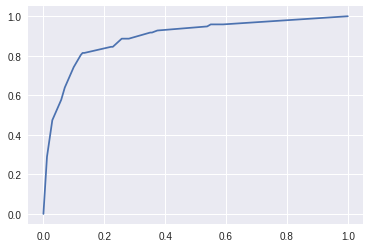

In [14]:
ax = plt.plot(roc[0],roc[1])

Decent enough! Let's play around a bit more

In [15]:
# Let's use cross validation to waste less data and compare to an svm:
from sklearn.model_selection import cross_val_predict

rf_predictions = cross_val_predict(forest, features, df['Survived'], cv=10)


from sklearn import svm

SVM = svm.SVC(kernel='linear', C=1)

svm_predictions = cross_val_predict(SVM, features, df['Survived'], cv=10)

In [16]:
print(metrics.f1_score(df['Survived'], rf_predictions))
print(metrics.accuracy_score(df['Survived'], rf_predictions))
print(metrics.f1_score(df['Survived'], svm_predictions))
print(metrics.accuracy_score(df['Survived'], svm_predictions))

0.75
0.81593714927
0.710365853659
0.786756453423


In [17]:
submission_data = pd.read_csv('../data/test.csv', index_col=0)

In [18]:
submission_continuous = normalize_continuous(submission_data, continuous_columns)
submission_discrete = one_hot(submission_data, discrete_columns)
submission_features = pd.concat([submission_discrete, submission_continuous], axis=1)

model = forest.fit(features, df['Survived'])
submission_predictions = model.predict(submission_features)

/home/dani/anaconda3/envs/titanic/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
submission = pd.DataFrame(submission_predictions, index=submission_data.index, columns=['Survived'])

In [20]:
# Once I fixed a stupid mistake, this got 0.708
submission.to_csv('../data/submission.csv')